In [1]:
# Plotting script for results
import os
import matplotlib.pyplot as plt
from read_results_helpers import *

In [27]:
total_hours = 8784
# Plotting results for cost and capacity
def plot_results(results_dir, color_dict, poi, outfile_suffix = '', pass_results=[], rm_plot=True):
    all_results = []
    max_result = 0
    fig, ax = plt.subplots(figsize=(10, 5))
    # Increase white space left and bottom and top
    fig.subplots_adjust(left=0.5, bottom=0.5, top=0.9)

    files = [f for f in os.listdir(results_dir) if f.endswith('.pickle')]

    if rm_plot == True:
        files.pop(files.index('all_firm_all.pickle'))
        files_sorted = sorted(files, key=lambda x: int(x.split('_')[2]))
        files_sorted = list(files_sorted)
        files_sorted.insert(0, 'all_firm_all.pickle')
    else:
        files_sorted = sorted(files, key=lambda x: float(x.split('_')[2].replace('.pickle', '').replace('p', '.')))

    print(files_sorted)

    # Loop over all case pickle files in all_firm_case folder
    for i,case_file in enumerate(files_sorted[:-3]):

        if pass_results == []:
            # Load results
            component_results = read_component_results(results_dir, case_file)
            # Calculate results
            results = get_result(component_results, total_hours, poi)
            # Sort results by value in descending order
            results = {k: v for k, v in sorted(results.items(), key=lambda item: item[1], reverse=True)}
            all_results.append(results)
        else:
            results = pass_results[1][i]

        if i==0 or len([x for x in results.values() if x != 0]) > 0:
        
  
            # Stacked bar plot of results
            bottom_value = 0
            if rm_plot == True:
                if case_file != files_sorted[-3]:
                    x_tick_label = files_sorted[i+1].replace('all_firm_', '').replace('.pickle', '').replace('{0}_'.format(i), '')
                else:
                    # x_tick_label = 'all firm'
                    # x_tick_label = 'no firm'
                    x_tick_label = [x for x in results.keys() if results[x] != 0][0]
            else:
                x_tick_label = case_file.replace('all_firm_', '').replace('.pickle', '').replace('p', '.')    

            for component in results:

                ax.bar(x_tick_label, results[component], width=0.25,
                        color=color_dict[component], bottom=bottom_value, label=component)
                bottom_value += results[component]

            # Get max result
            if sum(results.values()) > max_result:
                max_result = sum(results.values())
            
            # Get legend handles and labels for all_firm_all case and if that doesn't exist, for all_firm_1p0 case
            if case_file == 'all_firm_all.pickle' or case_file == 'all_firm_1p0.pickle':
                handles, labels = ax.get_legend_handles_labels()
                labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0].lower()))
       
    # Plot legend, label with second part of index of component_results, no box
    ax.legend(handles, labels, loc='upper left', fontsize='small', frameon=False, bbox_to_anchor=(1, 1))
    # Prevent legend from overlapping with plot
    fig.tight_layout()

    # Plot labels
    # ax.set_xlabel('Firm technology mix')
    if rm_plot == True:
        ax.set_xlabel('Firm technology that increases total cost least when removed')
    else:
        ax.set_xlabel('Natgas CCS price factor')
    if poi == 'cost':
        unit = '€'
    elif poi == 'capacity':
        unit = 'MW (or tCo2 for CO2 storage)'
    elif poi == 'normalized_cost':
        unit = '€/MWh covered demand'
    else:
        print('No unit defined for {0}'.format(poi))
        unit =  ''
    ax.set_ylabel('Total {0} [{1}]'.format(poi, unit))

    if rm_plot == True:
        ax.set_title('Smallest cost increase, solar/wind can be removed, no hydro/geo, no firm generators')
    else:
        ax.set_title('Natgas CCS price factor impact')

    # Title font size
    ax.title.set_size(16)
    # Distance between title and plot
    ax.title.set_position([.5, 1.3])
    # Avoid x label overlap with x ticks by rotating, center upper end of label with tick
    plt.setp(ax.get_xticklabels(), rotation=40, ha='right', rotation_mode='anchor')


    n_cases = len([case for case in os.listdir(results_dir) if case.endswith('.pickle')])
    # Axis limits
    ax.set_ylim(0, 1.2*max_result)
    # y log scale
    # ax.set_yscale('log')

    # Save plot
    plt.savefig(results_dir+'/total_{0}{1}.png'.format(poi, outfile_suffix), dpi=fig.dpi, bbox_inches='tight')
    plt.show()
    if pass_results == []:
        return all_results

['all_firm_all.pickle', 'all_firm_0_load_shedding.pickle', 'all_firm_1_zn_air_store.pickle', 'all_firm_2_sand_store.pickle', 'all_firm_3_redox_store.pickle', 'all_firm_4_onwind.pickle', 'all_firm_5_compressed_air_store.pickle', 'all_firm_6_hydrogen.pickle', 'all_firm_7_battery_storage.pickle', 'all_firm_8_phs.pickle', 'all_firm_9_load_shifting_backward.pickle', 'all_firm_9_solar-utility.pickle']


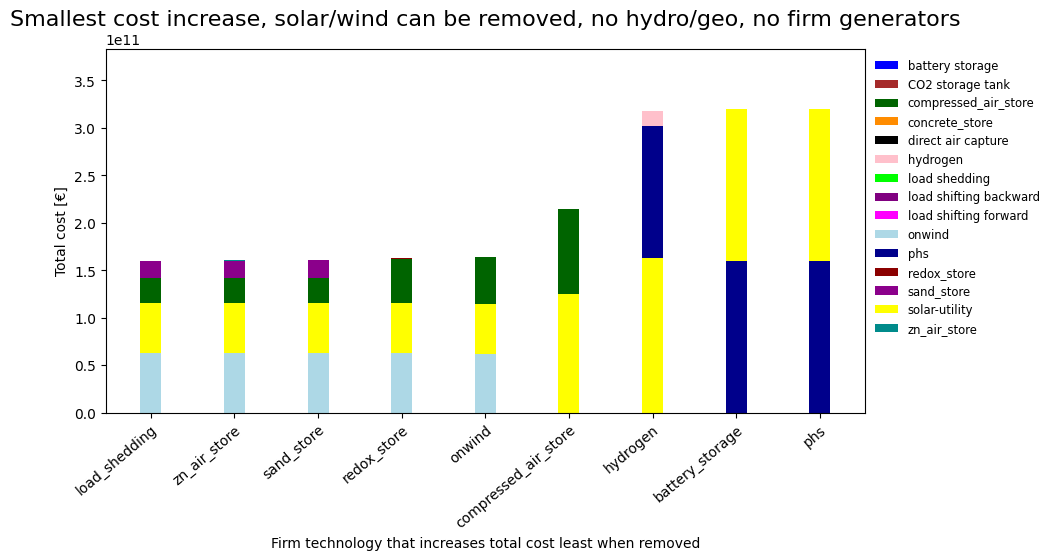

['all_firm_all.pickle', 'all_firm_0_load_shedding.pickle', 'all_firm_1_zn_air_store.pickle', 'all_firm_2_sand_store.pickle', 'all_firm_3_redox_store.pickle', 'all_firm_4_onwind.pickle', 'all_firm_5_compressed_air_store.pickle', 'all_firm_6_hydrogen.pickle', 'all_firm_7_battery_storage.pickle', 'all_firm_8_phs.pickle', 'all_firm_9_load_shifting_backward.pickle', 'all_firm_9_solar-utility.pickle']


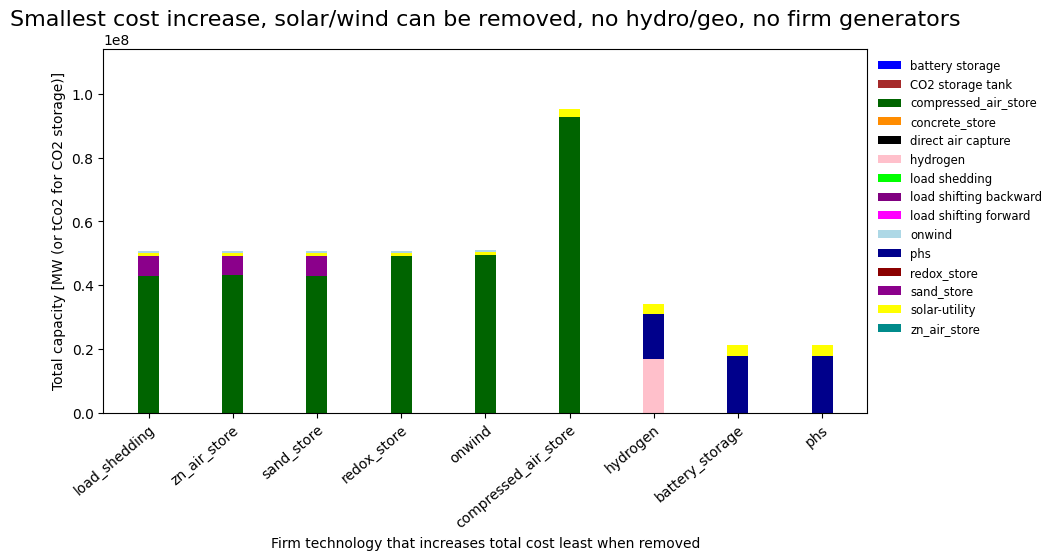

['all_firm_all.pickle', 'all_firm_0_load_shedding.pickle', 'all_firm_1_zn_air_store.pickle', 'all_firm_2_sand_store.pickle', 'all_firm_3_redox_store.pickle', 'all_firm_4_onwind.pickle', 'all_firm_5_compressed_air_store.pickle', 'all_firm_6_hydrogen.pickle', 'all_firm_7_battery_storage.pickle', 'all_firm_8_phs.pickle', 'all_firm_9_load_shifting_backward.pickle', 'all_firm_9_solar-utility.pickle']


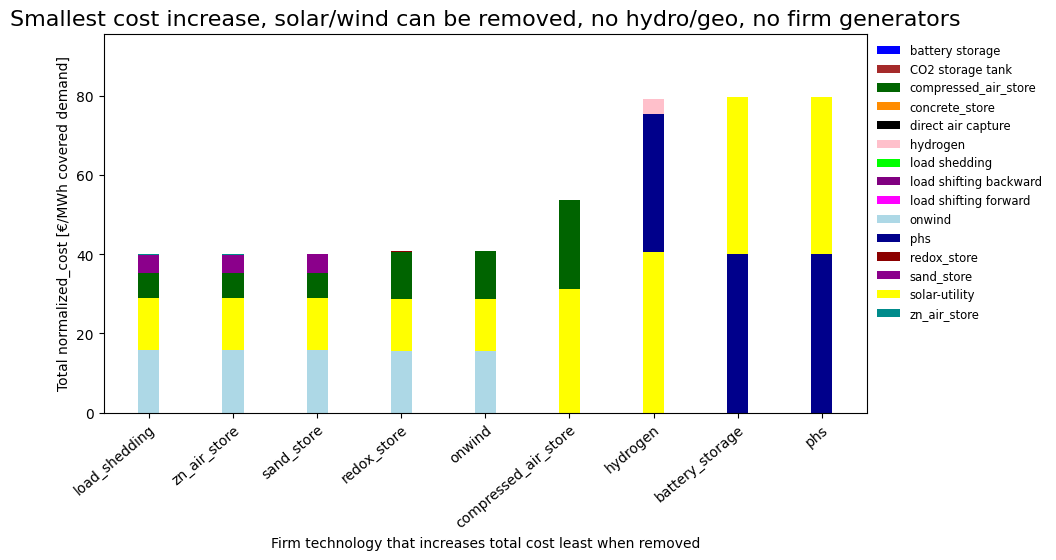

In [28]:
# Results directory
out_suff = '_all_stores_no_generators'
results_dir = 'output_data/all_firm_case'+out_suff
removal_plot = True
results_dir += '/plotting/' if removal_plot == True else '/'

# Get color map
color_dict = get_colors()


# Plot
costs = plot_results(results_dir, color_dict, 'cost', outfile_suffix=out_suff, rm_plot=removal_plot)
capacities = plot_results(results_dir, color_dict, 'capacity', outfile_suffix=out_suff, rm_plot=removal_plot)
if removal_plot == True:
    total_demand = abs(get_demand(results_dir, 'all_firm_all.pickle'))
else:
    total_demand = abs(get_demand(results_dir, 'all_firm_1p0.pickle'))

system_costs = [{} for i in range(len(costs))]
for i,case in enumerate(costs):
    for comp in case:
        system_costs[i][comp] = case[comp]/total_demand

plot_results(results_dir, color_dict, 'normalized_cost', outfile_suffix=out_suff, pass_results=['system_cost [€/MWh]', system_costs], rm_plot=removal_plot)